In [1]:
import numpy as np 
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
import sklearn 
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
import xgboost as xgb
from scipy import stats

pd.set_option('display.max_columns', 500)
import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

sns.set(font_scale=1.5, rc={"figure.figsize": (14, 10)})
sns.set_context("notebook")

/Users/s.bykov/opt/anaconda3/envs/venv_ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[Link](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022)


This data represents the results of a large product testing study. For each `product_code` you are given a number of product `attributes` (fixed for the code) as well as a number of `measurement` values for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (`loading`) to see whether or not it fails.

Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


In [2]:
df = pd.read_csv('data/train.csv')
df = df.sample(len(df))
df_sub = pd.read_csv('data/test.csv')
df_sub['failure'] = np.nan


df['type'] = 'train'
df_sub['type'] = 'test'

df_total = pd.concat([df, df_sub], axis=0)
df_total.reset_index(drop=True, inplace=True)

train = df_total[df_total['type'] == 'train']
test = df_total[df_total['type'] == 'test']

In [3]:
df_total.sample(10)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,type
29670,29670,F,178.46,material_5,material_6,6,4,8,4,21,17.886,9.561,16.573,16.361,10.295,18.847,11.917,16.020,19.183,11.106,14.193,16.856,13.601,14.911,241.435,NaN,test
15170,8713,B,83.87,material_5,material_5,8,8,3,10,7,17.490,12.125,18.399,17.387,10.763,19.726,10.352,16.754,17.087,11.707,17.081,14.488,17.201,14.343,644.227,0.0,train
21397,14893,C,84.08,material_7,material_8,5,8,7,11,6,18.248,11.373,17.709,18.596,12.291,17.925,10.820,15.253,20.569,13.635,17.344,15.526,NaN,20.089,639.748,0.0,train
26630,26630,F,102.36,material_5,material_6,6,4,7,8,5,17.561,11.802,16.500,17.376,13.062,19.873,13.598,17.100,17.499,NaN,12.713,16.678,13.812,14.815,775.279,NaN,test
40564,40564,H,193.57,material_7,material_7,7,9,2,11,11,18.186,11.853,17.604,16.585,12.989,19.740,11.903,16.768,19.777,9.193,17.208,NaN,14.089,NaN,NaN,NaN,test
26768,26768,F,137.94,material_5,material_6,6,4,10,10,17,16.576,12.024,15.642,17.806,NaN,18.479,11.520,15.070,17.236,13.097,17.771,NaN,14.428,13.117,662.792,NaN,test
2769,4344,A,151.89,material_7,material_8,9,5,16,4,3,17.391,10.921,16.763,16.514,11.685,19.003,10.890,16.421,21.858,11.123,15.671,16.462,14.266,19.166,637.732,1.0,train
35056,35056,G,247.03,material_5,material_6,9,7,4,6,6,18.509,10.994,17.040,19.848,10.687,16.688,9.594,16.734,18.619,14.515,14.872,17.110,15.008,17.080,592.660,NaN,test
16176,23477,E,77.44,material_7,material_6,6,9,3,10,3,18.318,12.070,18.238,18.481,11.629,20.628,11.641,15.146,18.855,10.992,15.172,18.518,15.411,15.688,NaN,0.0,train
41385,41385,H,111.81,material_7,material_7,7,9,4,5,5,17.811,11.305,17.659,17.339,12.356,16.570,13.026,15.861,18.506,10.247,14.327,16.882,NaN,17.062,NaN,NaN,test


# Exploratory Data Analysis

Great EDA was done in [this post on Kaggle](https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense/notebook), I will not repeat it here, but use some insights from it to understand the data.

In [4]:
df_total[['product_code', 'attribute_0','attribute_1', 'attribute_2', 'attribute_3',  'type']].drop_duplicates().sort_values(by='product_code')

,product_code,attribute_0,attribute_1,attribute_2,attribute_3,type
14,A,material_7,material_8,9,5,train
2,B,material_5,material_5,8,8,train
0,C,material_7,material_8,5,8,train
1,D,material_7,material_5,6,6,train
9,E,material_7,material_6,6,9,train
26570,F,material_5,material_6,6,4,test
31992,G,material_5,material_6,9,7,test
37099,H,material_7,material_7,7,9,test
42117,I,material_7,material_5,9,5,test


After looking at `attribute_0/1` for a given `product_code` one sees that code defines a group of attributes. 

`attribute_0` is either materials 5 or 7, and both variants present in test and train samples. On the other hand, material for `attribute_1` is `5,6,8` in the train sample and `5,6,7` in the test sample.

At the same time, `attribute_2/3` are varying within a group of material used. We should probably save those features to aid the model.

`attribute_0` will be encoded as a binary, and `attribute_1` as a one-hot. 

# Data transformation

In [5]:
df_total.groupby('product_code').agg(['max'])

,id,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,type
,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max
product_code,,,,,,,,,,,,,,,,,,,,,,,,,,
A,5099,342.88,material_7,material_8,9,5,26,18,19,21.022,16.484,21.425,21.023,15.352,22.472,15.045,20.199,24.960,17.392,19.774,20.598,21.515,22.447,1084.267,1.0,train
B,10349,350.35,material_5,material_5,8,8,22,27,21,21.499,15.252,20.757,21.056,15.178,23.328,15.412,22.479,25.640,15.360,22.713,19.650,20.883,24.094,1107.479,1.0,train
C,16114,385.86,material_7,material_8,5,8,29,23,21,21.336,15.379,20.432,21.543,14.906,22.752,15.154,19.896,23.439,16.153,19.374,22.303,21.626,23.139,1104.444,1.0,train
D,21226,324.57,material_7,material_5,6,6,27,29,24,21.267,15.102,20.620,21.329,15.269,22.482,14.940,21.761,22.207,17.663,19.371,19.974,20.294,22.696,1178.683,1.0,train
E,26569,346.97,material_7,material_6,6,9,21,28,24,21.248,15.281,20.616,20.885,15.419,23.807,14.735,21.459,24.973,17.354,18.927,20.284,18.411,22.246,1312.794,1.0,train
F,31991,351.83,material_5,material_6,6,4,30,33,28,21.117,15.205,20.956,21.183,15.460,22.665,14.794,21.898,23.170,15.445,21.677,19.748,20.126,21.580,1242.786,NaN,test
G,37098,362.70,material_5,material_6,9,7,26,26,16,21.389,15.623,20.445,20.942,15.828,23.092,15.086,22.259,24.950,15.355,19.377,21.292,22.097,21.671,1137.358,NaN,test
H,42116,385.57,material_7,material_7,7,9,23,20,19,21.294,15.268,21.681,20.971,15.470,22.652,15.091,23.354,23.656,17.686,19.262,20.045,22.012,22.116,1109.148,NaN,test


I will use a simple scaler for numerical attributes, and a one-hot encoder for categorical attributes.

In [6]:
def my_data_transformer(df):


    output_cols_include_categorical = ['loading',  'attribute_2', 'attribute_3',  'measurement_0',
        'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4',
        'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8',
        'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12',
        'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16',
        'measurement_17', 'attribute_0_material_5',
        'attribute_0_material_7', 'attribute_1_material_5',
        'attribute_1_material_6', 'attribute_1_material_8']


    df_scaled = df.copy()
    df_scaled['loading'] =  df_scaled['loading']/400

    for col in df.columns:
        if 'measurement' in col:
            df_scaled[col] = df[col].values / 30
            
        if 'attribute_2' in col or 'attribute_3' in col:
            df_scaled[col] = df[col].values / 10


    df_scaled['measurement_17'] = df['measurement_17'] / 1500

    df_scaled['ohe0_7'] = df_scaled['attribute_0'].apply(lambda x: 1 if x == 'material_7' else 0)
    df_scaled.drop(['attribute_0'], axis=1, inplace=True)
    df_scaled['ohe1_6'] = df_scaled['attribute_1'].apply(lambda x: 1 if x == 'material_6' else 0)
    df_scaled['ohe1_8'] = df_scaled['attribute_1'].apply(lambda x: 1 if x == 'material_8' else 0)
    df_scaled.drop(['attribute_1'], axis=1, inplace=True)

    #see https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense/notebook#The-integer-columns

    return df_scaled

In [7]:
df_scaled = my_data_transformer(df_total)
df_scaled.sample(10)

,id,product_code,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,type,ohe0_7,ohe1_6,ohe1_8
42667,42667,I,0.211850,0.9,0.5,0.366667,0.300000,0.200000,0.509067,0.444733,0.547067,0.560500,0.342667,0.640700,0.376100,0.540267,0.598167,0.370067,0.565367,0.541333,0.479400,0.530400,0.404023,NaN,test,1,0,0
36356,36356,G,0.271175,0.9,0.7,0.233333,0.333333,0.066667,0.590900,0.355967,NaN,0.596533,0.442767,0.553767,0.378833,0.554867,0.625533,0.318200,0.525067,0.610867,0.424067,0.611433,0.352969,NaN,test,0,1,0
4925,22744,E,0.197425,0.6,0.9,0.200000,0.333333,0.066667,0.611500,0.369900,0.507600,0.607400,0.391600,0.665867,0.367733,0.475967,0.673667,0.403200,0.507833,0.525433,0.538700,0.621367,0.435965,0.0,train,1,1,0
4047,3026,A,0.211600,0.9,0.5,0.233333,0.300000,0.166667,0.575967,0.429900,0.614733,0.555567,0.348500,NaN,0.367267,0.529200,NaN,0.394833,0.534700,0.558233,0.455200,0.625800,NaN,0.0,train,1,0,1
46780,46780,I,0.255650,0.9,0.5,0.000000,0.633333,0.233333,0.568200,0.330033,0.595200,0.570567,0.344600,0.661433,0.321633,0.590533,0.575867,0.485333,0.445100,0.538867,0.493067,0.517733,0.412107,NaN,test,1,0,0
35233,35233,G,0.242025,0.9,0.7,0.233333,0.133333,0.233333,0.585733,0.361400,0.523500,0.598533,0.373033,0.623400,0.429200,0.492400,0.641933,0.393200,0.485733,NaN,0.555833,0.493333,0.468901,NaN,test,0,1,0
23117,10323,B,0.391975,0.8,0.8,0.366667,0.300000,0.133333,0.610933,0.348267,0.528133,0.592100,0.373833,0.667267,0.332367,0.563433,0.630033,0.457867,0.451133,0.509733,0.513200,0.475300,NaN,0.0,train,0,0,0
24127,11629,C,0.477100,0.5,0.8,0.300000,0.133333,0.400000,0.532000,0.326600,0.631267,0.522133,0.401933,0.609167,0.351500,0.552600,0.698333,0.396967,0.535400,0.545500,0.476733,0.435900,0.464294,0.0,train,1,0,1
36890,36890,G,0.271125,0.9,0.7,0.200000,0.300000,0.033333,0.577100,0.404700,0.587033,NaN,0.438867,0.623700,0.307300,0.474633,0.723300,0.390133,0.486133,0.464800,0.503033,0.580800,0.406453,NaN,test,0,1,0
33345,33345,G,0.327300,0.9,0.7,0.100000,0.333333,0.166667,0.557767,0.359267,0.560733,0.556400,0.402700,0.614333,0.369100,0.580333,0.514233,0.427367,0.538367,0.610467,0.501767,0.444600,0.342347,NaN,test,0,1,0


# Missing values

look at the missing values in each `product_code`

In [8]:
df_scaled.groupby('product_code', dropna=False).agg(lambda x: 100*x.isna().sum()/len(x)) #get percentage of missing values per product code per feature

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,type,ohe0_7,ohe1_6,ohe1_8
product_code,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.960784,0.0,0.0,0.0,0.0,0.0,1.333333,2.000000,2.960784,3.431373,3.450980,3.666667,4.411765,5.039216,5.803922,6.392157,6.470588,6.196078,7.392157,7.607843,8.352941,0.0,0.0,0.0,0.0,0.0
B,0.0,0.780952,0.0,0.0,0.0,0.0,0.0,1.600000,1.809524,2.190476,2.533333,3.676190,4.038095,4.780952,5.085714,5.466667,5.676190,6.876190,6.495238,7.390476,8.742857,8.571429,0.0,0.0,0.0,0.0,0.0
C,0.0,0.849957,0.0,0.0,0.0,0.0,0.0,1.318300,2.133565,2.810061,3.156982,3.330442,4.197745,4.683435,4.874241,5.134432,5.776236,6.261925,7.424111,7.597572,7.666956,8.135299,0.0,0.0,0.0,0.0,0.0
D,0.0,0.958529,0.0,0.0,0.0,0.0,0.0,1.349765,1.877934,2.171362,3.051643,3.345070,3.814554,4.655712,4.714397,5.633803,6.142410,7.413928,7.668232,7.942097,7.863850,9.115806,0.0,0.0,0.0,0.0,0.0
E,0.0,1.160397,0.0,0.0,0.0,0.0,0.0,1.572150,2.283361,2.564103,2.807412,3.836796,3.967808,4.548007,4.753884,5.633539,6.176305,6.419614,7.430283,7.486431,7.842036,8.852704,0.0,0.0,0.0,0.0,0.0
F,0.0,1.235706,0.0,0.0,0.0,0.0,0.0,1.420140,2.028772,2.231649,3.024714,3.246035,4.075987,4.352637,4.407968,5.256363,6.289192,6.067872,7.008484,7.524899,8.410181,8.539284,100.0,0.0,0.0,0.0,0.0
G,0.0,0.959467,0.0,0.0,0.0,0.0,0.0,1.723125,2.290973,2.467202,3.172117,3.250441,4.268651,4.092422,5.717642,6.011357,6.109262,6.050519,6.677110,7.049148,8.576464,8.419816,100.0,0.0,0.0,0.0,0.0
H,0.0,1.016341,0.0,0.0,0.0,0.0,0.0,1.693902,1.753687,2.730171,2.989239,3.886010,3.746513,4.623356,5.360701,5.520128,6.177760,6.456756,7.054603,7.712236,8.031088,8.628936,100.0,0.0,0.0,0.0,0.0
I,0.0,1.071155,0.0,0.0,0.0,0.0,0.0,1.511094,1.798011,2.371844,2.830910,3.500383,4.188982,4.342005,5.107116,5.107116,5.298393,6.522571,6.981637,7.402448,7.287682,7.918898,100.0,0.0,0.0,0.0,0.0


My initial experiments show that the distribution of float features is quite normal-looking (when looking at pairplots), although I did not test it formally. 

On the ~half of the data (where all all feature in a row is available) per each group we can learn mean and covariance of `measurement_3`-`measurement_17` features.

What I have in mind is that when we have only ONE feature missing, we can use the distribution of all other features to impute the missing value based on the mean and covariance of their distribution (conditional probability of a missing feature given a leared mean/covariance).


82% data of all groups would have all data available or imputed. Other 18% would have a simpler impuation, say, median of the group.

In general, the approach can be extended to more than one missing feature, but I am not sure if it is worth it. For instance, imputing simultaneously two features would give you 95-96% data purity (without missing).

My quick tests show that the imputation is not very effective and affect results only marginally, so I opt to leave it out and use per-group mean/median imputation.

In [9]:
df_scaled.groupby(['product_code', 'attribute_2', 'attribute_3']).agg('median')

,,,id,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,ohe0_7,ohe1_6,ohe1_8
product_code,attribute_2,attribute_3,,,,,,,,,,,,,,,,,,,,,,,,
A,0.9,0.5,2549.5,0.304900,0.333333,0.133333,0.166667,0.593600,0.390533,0.570933,0.583600,0.391200,0.634367,0.381433,0.537933,0.648667,0.411317,0.519533,0.534217,0.479233,0.544117,0.468694,0.0,1.0,0.0,1.0
B,0.8,0.8,7724.5,0.305900,0.200000,0.266667,0.266667,0.592767,0.391033,0.571700,0.584000,0.390500,0.633233,0.381033,0.537333,0.639733,0.397450,0.530367,0.536067,0.505000,0.555367,0.466475,0.0,0.0,0.0,0.0
C,0.5,0.8,13232.0,0.305225,0.233333,0.266667,0.166667,0.592700,0.391783,0.571233,0.583133,0.390867,0.634467,0.380867,0.537550,0.628067,0.373233,0.519117,0.536133,0.515200,0.543633,0.466534,0.0,1.0,0.0,1.0
D,0.6,0.6,18670.5,0.307625,0.233333,0.300000,0.233333,0.592033,0.390567,0.570533,0.583917,0.390167,0.634267,0.380967,0.550900,0.636133,0.384233,0.520100,0.539250,0.488433,0.563117,0.467797,0.0,1.0,0.0,0.0
E,0.6,0.9,23898.0,0.306200,0.166667,0.300000,0.166667,0.593300,0.391633,0.570417,0.584800,0.389517,0.633800,0.380650,0.524533,0.652300,0.382567,0.519767,0.527283,0.502933,0.534317,0.467334,0.0,1.0,1.0,0.0
F,0.6,0.4,29280.5,0.302925,0.300000,0.400000,0.233333,0.592667,0.391100,0.571367,0.583783,0.390150,0.634667,0.380267,0.549667,0.603467,0.396867,0.517033,0.537700,0.478317,0.547383,0.468794,NaN,0.0,1.0,0.0
G,0.9,0.7,34545.0,0.307238,0.300000,0.233333,0.133333,0.592100,0.390983,0.570567,0.584367,0.390400,0.634000,0.379717,0.523300,0.638183,0.397200,0.519033,0.525983,0.515633,0.547633,0.467818,NaN,0.0,1.0,0.0
H,0.7,0.9,39607.5,0.304725,0.200000,0.200000,0.166667,0.593400,0.390600,0.571100,0.583283,0.390033,0.634767,0.380917,0.534867,0.643367,0.384850,0.519467,0.537700,0.516233,0.573167,0.467042,NaN,1.0,0.0,0.0
I,0.9,0.5,44730.5,0.305638,0.133333,0.333333,0.233333,0.593700,0.391167,0.571150,0.583467,0.389733,0.635167,0.381067,0.536967,0.638800,0.413400,0.545000,0.548867,0.504433,0.555467,0.466992,NaN,1.0,0.0,0.0


In [10]:
#median imputing per group
df_scaled = df_scaled.fillna(df_scaled.groupby(['product_code', 'attribute_2', 'attribute_3']).transform('median'))

#add features and their interaction (experimentally), see https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense/
df_scaled['m_3_missing'] = df_scaled.measurement_3.isna().astype(int)
df_scaled['m_5_missing'] = df_scaled.measurement_5.isna().astype(int)
df_scaled['loading_measurement17']  = df_scaled.loading * df_scaled.measurement_17
df_scaled['loading_measurement5']  = df_scaled.loading * df_scaled.measurement_5
df_scaled['measurement_17_measurement_17']  = df_scaled.measurement_17 * df_scaled.measurement_17
df_scaled['loading_loading']  = df_scaled.loading * df_scaled.loading
df_scaled['attribute_2_attribute_3']  = df_scaled.attribute_2 * df_scaled.attribute_2



# Model and Cross-validation

For caveats of cross-validation in this particular problem, see [this post](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/341896).

In [11]:
df_scaled_train, df_scaled_test = sklearn.model_selection.train_test_split(df_scaled.query('type=="train"'), test_size=0.3, random_state=42, stratify=df_scaled.query('type=="train"').failure)
print('train size', len(df_scaled_train))
print('test size', len(df_scaled_test))

train size 15942
test size 10628


Here we make a custom GroupKFold cross-validator to iterate over groups of products so that we fit a model on three different groups of products at once and test it on the other two. 

The fraction if positive and negative samples is the approximately same in all groups, so we neglect stratification over target.

In [12]:
class ProductCodeFold:
    def __init__(self):
        self.n_splits = 10
        self.folds = [
        (['A', 'B', 'C'], ['D', 'E']),
        (['A', 'B', 'D'], ['C', 'E']),
        (['A', 'B', 'E'], ['C', 'D']),
        (['A', 'C', 'D'], ['B', 'E']),
        (['A', 'C', 'E'], ['B', 'D']),
        (['A', 'D', 'E'], ['B', 'C']),
        (['B', 'C', 'D'], ['A', 'E']),
        (['B', 'C', 'E'], ['A', 'D']),
        (['B', 'D', 'E'], ['A', 'C']),
        (['C', 'D', 'E'], ['A', 'B']),
    ]

    def split(self, X, y=None, groups=None):
        for train_codes, test_codes in self.folds:
            idx_train = np.where(np.isin(groups, train_codes))[0]
            idx_test = np.where(np.isin(groups, test_codes))[0]
            yield idx_train, idx_test
    
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits



mycv = ProductCodeFold()

#scaling of the positive and negative features in the xgboost model
scale_pos_weight = np.sum(df_scaled_train.failure==0)/np.sum(df_scaled_train.failure==1)

features = [col for col in df_scaled.columns if col not in ['product_code', 'failure', 'type', 'id']]

#features as they went in feature importance in on of the RF runs
#features = ['loading', 'loading_measurement17', 'measurement_17',
#       'measurement_5', 'measurement_6', 'measurement_4',
#       'measurement_15', 'measurement_13', 'measurement_10',
#       'measurement_8',]

A test run of the cross-validation 

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_args = {'criterion': 'gini', 'bootstrap': True, 'oob_score': False,  'n_jobs': -1, 'warm_start': False, 'class_weight': 'balanced_subsample'}

#clf_param_grid = {
#           'n_estimators': [50, 75,100, 150],
#           'max_depth': [2],
#            'min_samples_split': [10],
#            }

clf_param_grid = {
              'n_estimators': 50,
                'max_depth': 2,
                'min_samples_split': 2,
                'max_features': 0.7,
                'max_samples': 0.5,
}

clf = RandomForestClassifier(**clf_args|clf_param_grid)



My initial tests with GridSearchCV and RandomizedSearchCV showed that the best hyperparameters (in terms of under- and over-fitting) are close to the one I selected above, but the exhaustive search is very time consuming.

In [14]:
cv_res = sklearn.model_selection.cross_validate(estimator = clf, X = df_scaled_train[features].values, y = df_scaled_train.failure.values, groups = df_scaled_train.product_code.values, scoring='roc_auc', cv = mycv, n_jobs = -1, verbose = 1, return_train_score=True, return_estimator=True)

# cv_rf = sklearn.model_selection.GridSearchCV(estimator = clf, scoring='roc_auc', cv = mycv, param_grid = clf_param_grid, n_jobs = -1, verbose = 1, return_train_score=True, refit = True)
# cv_rf.fit(X = df_scaled_train[features].values, y = df_scaled_train.failure.values, groups = df_scaled_train.product_code.values)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.9s finished


cv results
mean train roc_auc score' 0.602 +/- 0.004
mean validation roc_auc score' 0.589 +/- 0.006
test roc_auc: 0.588


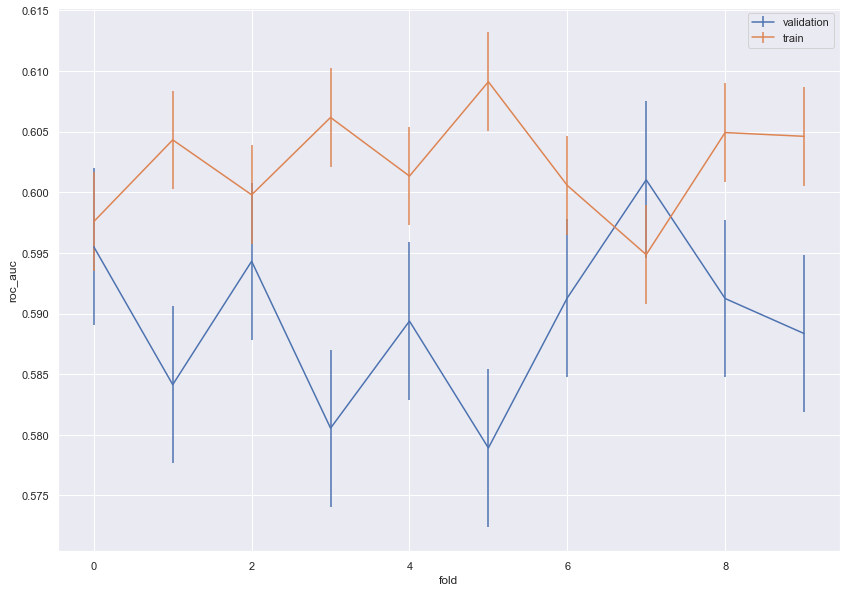

In [21]:
print('cv results')
print(f"mean train roc_auc score' {cv_res['train_score'].mean():.3f} +/- {cv_res['train_score'].std():.3f}")
print(f"mean validation roc_auc score' {cv_res['test_score'].mean():.3f} +/- {cv_res['test_score'].std():.3f}")


plt.errorbar(range(len(cv_res['test_score'])), cv_res['test_score'], yerr=cv_res['test_score'].std(), label='validation')
plt.errorbar(range(len(cv_res['train_score'])), cv_res['train_score'], yerr=cv_res['train_score'].std(), label='train')
plt.xlabel('fold')
plt.ylabel('roc_auc')
plt.legend()

best_model = cv_res['estimator'][cv_res['test_score'].argmax()]


y_pred_test = best_model.predict_proba(df_scaled_test[features].values)[:,1]
test_roc_auc = sklearn.metrics.roc_auc_score(df_scaled_test['failure'], y_pred_test)
print(f"test roc_auc: {test_roc_auc:.3f}")


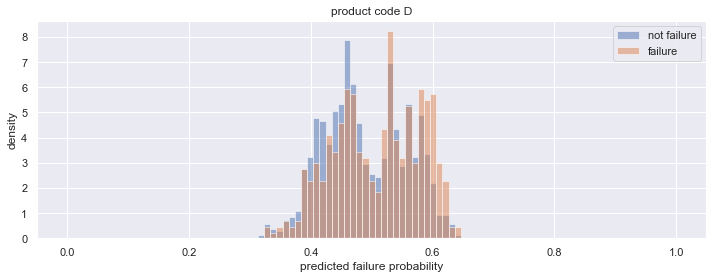

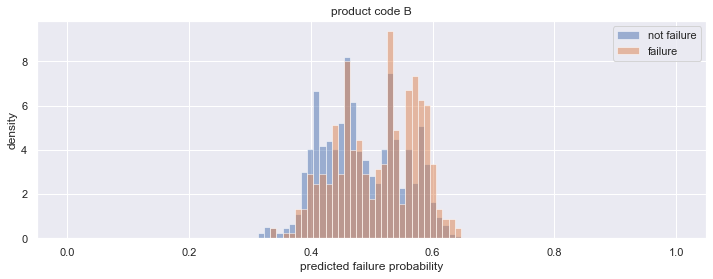

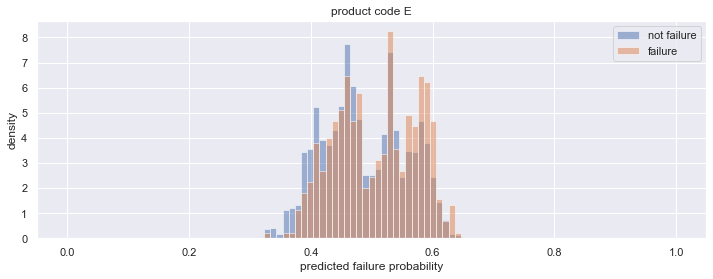

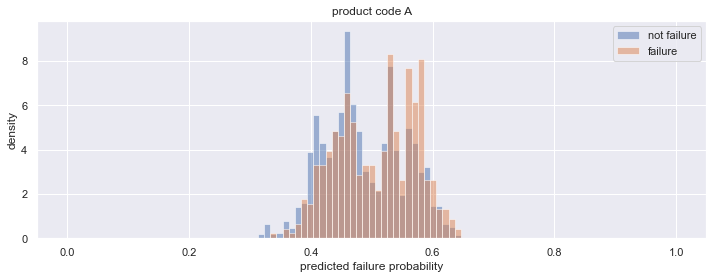

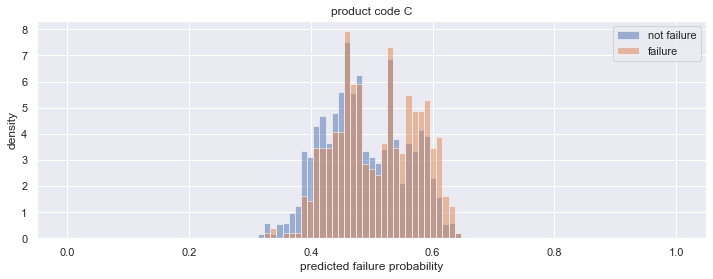

In [20]:
for group in df_scaled_test.product_code.unique():

    fig,  ax =  plt.subplots( figsize = (12,4))
    y_pred_test = best_model.predict_proba(df_scaled_test.query('product_code==@group')[features].values)[:,1]
    ax.hist(y_pred_test[df_scaled_test.query('product_code==@group')['failure']==0],  bins=np.linspace(0,1,100), alpha=0.5, label = 'not failure', density=True);
    ax.hist(y_pred_test[df_scaled_test.query('product_code==@group')['failure']==1],  bins=np.linspace(0,1,100), alpha=0.5, label='failure', density=True);
    ax.set_xlabel('predicted failure probability')
    ax.set_ylabel('density')
    ax.set_title(f'product code {group}')
    ax.legend()

* Firsts of all, note that there is a slight over-fitting of the dataset with random forest classifier. Hyperparameters may be tuned to improve the validation accuracy, but I could not find an obvious combination of hyperparameters that would improve the performance. CV score for `roc-auc=0.59`
* The distribution of failure probability for failed and not failed test examples are very similar, which exaplains a low roc-auc score and the fact that the model is only marginally better than random guessing (`roc-auc = 0.5`)

<AxesSubplot:>

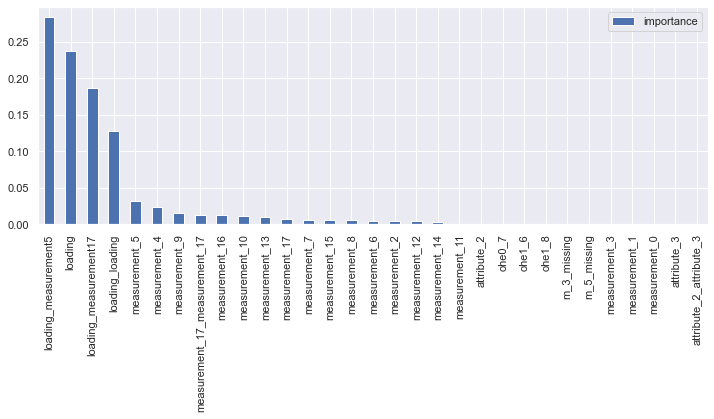

In [16]:
df_feature_importance = pd.DataFrame(best_model.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)
df_feature_importance.plot(kind='bar', figsize=(12,4))

Only a few features seem to be 'important', namely `loading`, `measurement_17`, `measurement_5` and their interactions.

test sample submission

In [17]:
submission = pd.DataFrame({'id': df_scaled.query('type=="test"').id,
                           'failure': best_model.predict_proba(df_scaled.query('type=="test"')[features].values)[:,1]})
submission.to_csv('data/submission_rf.csv', index=False)
submission

,id,failure
26570,26570,0.474206
26571,26571,0.444140
26572,26572,0.454259
26573,26573,0.449837
26574,26574,0.610817
...,...,...
47340,47340,0.537354
47341,47341,0.386775
47342,47342,0.396234
47343,47343,0.514569
